In [3]:
%load_ext autoreload
%autoreload 2

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import seaborn as sns
import tabulate
import torch
from torch import tensor
import tqdm
from typing import Any, Iterable

import weight_formats.experiments as E
import weight_formats.experiments.qat as EQ
import plot_utils

import logging
logging.basicConfig(level=logging.WARNING, force=True)
matplotlib.rcParams.update({"axes.spines.top": False, "axes.spines.right": False, "legend.frameon": False})

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
def count_instances(task: EQ.Task) -> int:
    import oe_eval.tasks.oe_eval_tasks
    oe_task = oe_eval.tasks.oe_eval_tasks.TASK_REGISTRY[task.name](task_name=task.name)
    oe_task.download()
    docs = list(oe_task.validation_docs())
    if task.limit:
        docs = docs[:task.limit]
    return len(docs)

instance_counts = {task.name: count_instances(task) for task in EQ.TASKS}
print(tabulate.tabulate(dict(name=k, count=v) for k, v in instance_counts.items()))
display(instance_counts)

----------------  ----
arc_challenge:mc   299
arc_easy:mc        570
boolq             3270
csqa:mc           1221
hellaswag         1000
openbookqa:mc      500
piqa              1838
socialiqa:mc      1954
winogrande        1267
----------------  ----


{'arc_challenge:mc': 299,
 'arc_easy:mc': 570,
 'boolq': 3270,
 'csqa:mc': 1221,
 'hellaswag': 1000,
 'openbookqa:mc': 500,
 'piqa': 1838,
 'socialiqa:mc': 1954,
 'winogrande': 1267}

In [2]:
runs = E.runs("20250611-downstream-baselines")
print(len(runs))

11


In [65]:
df = pd.DataFrame.from_records([
    dict(model=run.config.model.split("/")[-1],
         task=task.replace(":mc", ""),
         variant="mc" if task.endswith(":mc") else "cf",
         score=run.summary.direct_cast[task].primary_score,
         duration=run.summary.direct_cast[task]._duration)
    for run in runs
    for task in run.summary.direct_cast
])
print(len(df))
df["model_size"] = df.model.apply(lambda m: 14e9 if m == "phi-4" else float(re.search(r"\b([0-9.]+)B\b", m.upper()).group(1))*1e9)
df["model_family"] = df.model.apply(lambda m: re.match(r"[a-zA-Z]+", m).group(0))
df.head()

198


,model,task,variant,score,duration,model_size,model_family
0,Llama-3.2-1B,arc_challenge,mc,0.334448,7.178970,1.000000e+09,Llama
1,Llama-3.2-1B,arc_easy,mc,0.561404,11.229900,1.000000e+09,Llama
2,Llama-3.2-1B,piqa,mc,0.498368,29.009329,1.000000e+09,Llama
3,Llama-3.2-1B,winogrande,cf,0.595896,38.207194,1.000000e+09,Llama
4,Llama-3.2-1B,csqa,cf,0.516790,82.940650,1.000000e+09,Llama


In [67]:
order = [
    'Llama-3.2-1B',
    'Llama-3.2-3B',
    'Llama-3.1-8B',
    'Qwen2.5-0.5B',
    'Qwen2.5-1.5B',
    'Qwen2.5-3B',
    'Qwen2.5-7B',
    'phi-4'
]

(df.groupby(["model", "task"]).apply(lambda d: d.loc[d.score.idxmax()], include_groups=False)
 .reset_index()
 .pipe(lambda d: d.assign(desc=d.apply(lambda s: f"{s.score:.3f} ({s.variant})", axis=1)))
 .pipe(lambda d: d[d.model.isin(order)])
 .pivot(index="model", columns=["task"], values="desc")
 .loc[order]
)

task,arc_challenge,arc_easy,boolq,csqa,hellaswag,openbookqa,piqa,socialiqa,winogrande
model,,,,,,,,,
Llama-3.2-1B,0.385 (cf),0.600 (cf),0.642 (cf),0.517 (cf),0.654 (cf),0.430 (mc),0.750 (cf),0.469 (cf),0.596 (cf)
Llama-3.2-3B,0.712 (mc),0.816 (mc),0.739 (cf),0.640 (mc),0.749 (cf),0.628 (mc),0.776 (cf),0.624 (mc),0.697 (cf)
Llama-3.1-8B,0.806 (mc),0.902 (mc),0.820 (cf),0.704 (mc),0.808 (cf),0.760 (mc),0.817 (cf),0.648 (mc),0.735 (cf)
Qwen2.5-0.5B,0.518 (mc),0.723 (mc),0.642 (mc),0.510 (mc),0.518 (cf),0.512 (mc),0.710 (cf),0.550 (mc),0.558 (cf)
Qwen2.5-1.5B,0.786 (mc),0.904 (mc),0.732 (cf),0.722 (mc),0.686 (cf),0.728 (mc),0.764 (mc),0.687 (mc),0.639 (cf)
Qwen2.5-3B,0.836 (mc),0.930 (mc),0.798 (mc),0.774 (mc),0.784 (mc),0.808 (mc),0.819 (mc),0.734 (mc),0.689 (cf)
Qwen2.5-7B,0.903 (mc),0.960 (mc),0.846 (cf),0.850 (mc),0.901 (mc),0.870 (mc),0.865 (mc),0.782 (mc),0.729 (cf)
phi-4,0.906 (mc),0.970 (mc),0.873 (mc),0.762 (mc),0.893 (mc),0.826 (mc),0.866 (mc),0.766 (mc),0.766 (cf)


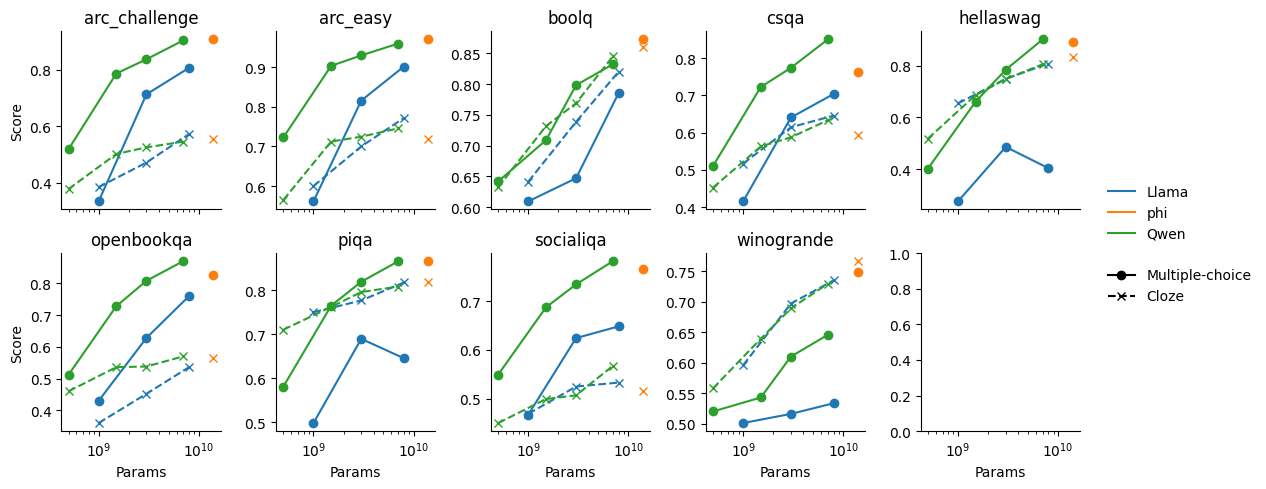

In [103]:
model_families = [
    (m, dict(label=m, color=color))
    for m, color in zip(df.model_family.unique(), sns.color_palette())
    if m != "gemma"
]
variants = [
    ("mc", dict(ls="-", marker="o", label="Multiple-choice")),
    ("cf", dict(ls="--", marker="x", label="Cloze")),
]

fig, axs = plt.subplots(2, 5, figsize=(11, 5), sharex=True)
task = "arc_challenge"

for task, ax in zip(sorted(df.task.unique()), axs.flatten()):
    for family, fargs in model_families:
        for variant, vargs in variants:
            g = df[(df.task == task) & (df.model_family == family) & (df.variant == variant)].sort_values("model_size")
            ax.plot(g.model_size, g.score, **{**fargs, **vargs})
    ax.set_title(task)
    ax.set_xscale("log")
for ax in axs[-1, :]:
    ax.set_xlabel("Params")
for ax in axs[:, 0]:
    ax.set_ylabel("Score")
fig.legend(
    handles=plot_utils.build_legend_handles(*model_families, "", *variants),
    bbox_to_anchor=(1, 0.5), loc="center left",
)
fig.tight_layout()
